# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.
Построим модель, которая по фотографии определит приблизительный возраст человека.

## Исследовательский анализ данных

In [2]:
import pandas as pd
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [4]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [6]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


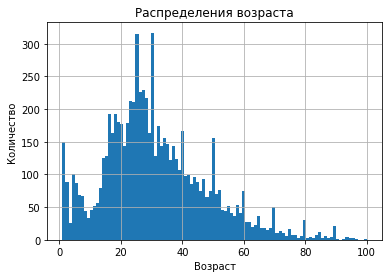

In [7]:
labels['real_age'].hist(bins=100)
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.title('Распределения возраста')
plt.show()

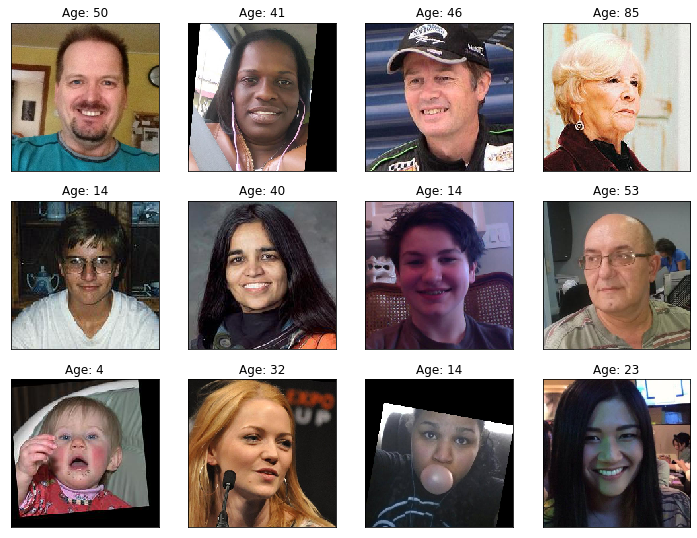

In [8]:
features, target = next(train_gen_flow)
fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.title( 'Age: ' + str(target[i]))
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Для обучения модели у нас в вашем распоряжении 7591 фотографий людей с указанием возраста. Средний возраст людей на фото 31 год. Для обучения модели исользуются люди возрастом от 1 года до 100 лет. Больше всего фотографий в диапазоне от 20 до 41 года.

## Обучение модели

Напишем функции для выгрузки данных, создания и обучении модели.

```python

<def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25,
                                       rescale=1./255, horizontal_flip=True)

    train_datagen_flow = train_datagen.flow_from_dataframe(
            dataframe=labels,
            directory= path + 'final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=16,
            class_mode='raw',
            subset='training',
            seed=12345)

    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path+'labels.csv')
    validation_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1. / 255)

    val_datagen_flow = validation_datagen.flow_from_dataframe(
        dataframe=labels,
        directory= path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return val_datagen_flow


def create_model(input_shape):
    optimazer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)

    backbone.trainable = True

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mse',
                  optimizer=optimazer, metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=32, epochs=5,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, epochs=epochs)

    return model>

```

```

Train for 356 steps, validate for 119 steps
Epoch 1/5
356/356 - 118s - loss: 204.7803 - mae: 10.4874 - val_loss: 689.5309 - val_mae: 21.3031
Epoch 2/5
356/356 - 38s - loss: 81.2300 - mae: 6.8721 - val_loss: 179.9665 - val_mae: 9.9204
Epoch 3/5
356/356 - 37s - loss: 56.0586 - mae: 5.6896 - val_loss: 74.6485 - val_mae: 6.5631
Epoch 4/5
356/356 - 37s - loss: 45.3701 - mae: 5.1323 - val_loss: 72.3621 - val_mae: 6.3029
Epoch 5/5
356/356 - 37s - loss: 32.4965 - mae: 4.3853 - val_loss: 67.0210 - val_mae: 6.1035

119/119 - 9s - loss: 67.0210 - mae: 6.1035
Test MAE: 6.1035


Модель сверточной нейронной сети построена на ResNet50. В качестве функции потерь использована MSE.
За 5 эпох обучения удалось уменьшить значение средней абсолютной ошибки MAE с 21.30 до 6.10 на валидационной выборке. Увеличение количества эпох возможно улучшит результат.

## Анализ обученной модели

Обученная модель позволяет с высокой точностью предсказывать возраст покупателей. Значение МАЕ нашей модели равное 6.10 решает поставленную задачу получения значения MAE на тестовой выборке не больше 8.
Учитывая, что людей можно разделить по следующим возрастным категориям [young_period: до 21 года],[mature_period1: 21 — 35 лет],[mature_period2: 35 — 60 лет],[elderly_period: 60 лет и старше], полученнная модель позволит анализировать покупки и предлагать товары, которые могут заинтересовать покупателей необходимой возрастной группы, а так же даст возможность пресекать продажу алкогольной и табачной продукции несовершеннолетним.